In [1]:
import pickle as pkl
from scipy import optimize, sparse
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import lstsq, inv
import scipy as sp
from scipy import sparse
from scipy import optimize
import scipy.stats as stats
import math

import corner
import emcee
from tabulate import tabulate


**Problem 1:** Go back to the 11th data set (the last data set) from Problem 2 of Problem Set 2 and sample in the 6-dimensional space (5 linear amplitudes and the period T) with some sensible priors on all 6 parameters (we’ll discuss possible priors in class). Make a “corner plot” of the posterior sampling, and plot a sampling of 16 independent samples from the posterior in the space of the data, on the data.

In [2]:
with open("C:/Users/jessm/Documents/NYU/2nd Year/Data Analysis/data2.pkl", "rb") as handle:
    data = pkl.load(handle).T # check out that pesky little `.T`
print(data.shape)

# Dear all:
# - data[0] is the array of times (day units, say?)
# - data[1] is the array of uncertainties (m/s units, say?)

t=data[0]
sigma=data[1]

(13, 1024)


In [3]:
def guess100(T, DC, A1, A2):
    parenthesis= 2*np.pi*(T/100)
    return DC+(A1*np.sin(parenthesis))+(A2*np.cos(parenthesis))

def negloglike100(params):
    for i in zip(y, t, sigma):
        return np.sum((y - (guess100(t, *params)))**2/(sigma**2))

def guessextra(T, T0_B, DC, B1, B2):
    parenthesis= 2*np.pi*(T/T0_B)
    return DC+(B2*np.sin(parenthesis))+(B2*np.cos(parenthesis))

def negloglikeextra(params):
    for i in zip(y, t, sigma):
        return np.sum((y - (guessextra(t, *params)))**2/(sigma**2))

      fun: 4192.341882120344
 hess_inv: array([[2.74655974e-06, 6.54676114e-06, 7.06248102e-07],
       [6.54676114e-06, 3.54242271e-04, 2.95805623e-05],
       [7.06248102e-07, 2.95805623e-05, 9.70196023e-05]])
      jac: array([0.00000000e+00, 6.10351562e-05, 0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 96
      nit: 8
     njev: 24
   status: 2
  success: False
        x: array([0.03377263, 2.3140514 , 2.06095442])
[2.10361045 2.18777027 2.31038582 ... 2.72156329 2.63586151 2.52328978]
offset = 0.03377262711669915 amplitude 1 = 2.314051404725436 amplitude 2 = 2.0609544239058177
Final Amplitude = 3.0987686330426034


Text(0.5, 1.0, 'data set 11')

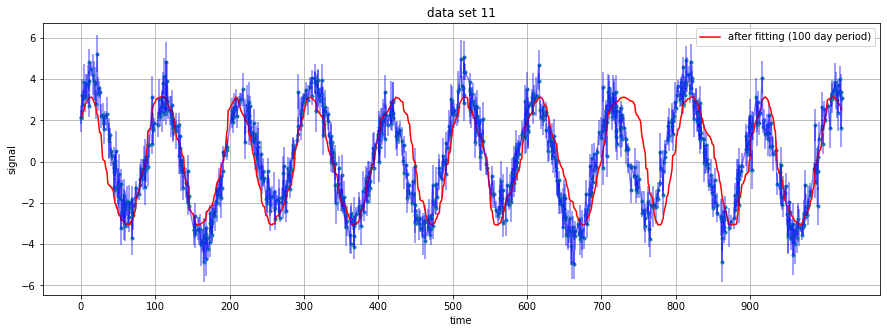

In [4]:
y=data[-1]
params100= [0, 1, 1]

model = optimize.minimize(negloglike100, params100) 
print(model)
y_fit = guess100(t, *model['x'][:])
print(y_fit)
print("offset =", model['x'][0], "amplitude 1 =", model['x'][1], "amplitude 2 =", model['x'][2])
print("Final Amplitude =", np.sqrt((model['x'][1])**2+((model['x'][2])**2)))
#plt.plot(y_fit, 'r', label='after fitting for third signal')


plt.figure(figsize=(15, 5))
plt.plot(t, y, '.')
plt.errorbar(t, y, yerr=sigma, color="b", alpha=0.5)
plt.plot(y_fit, color="r", label='after fitting (100 day period)')
plt.legend()


plt.xticks(np.arange(0, 1000, 100))
plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("signal")
plt.title("data set 11")

In [5]:
y=data[-1]
params1= [0, 1, 1] #DC1, A1, A2
params2 = [250,0, 1, 1] #period, DC2, A3, A4
paramsboth=params1+params2

      fun: 933.211175462096
 hess_inv: array([[ 5.00013008e-01, -7.81374095e-08, -3.69003051e-06,
         3.73450098e-04, -4.99986992e-01, -7.83981079e-06,
         1.23607512e-05],
       [-7.81374096e-08,  9.12643920e-05,  1.69667105e-06,
        -8.87327529e-05, -7.81374097e-08,  5.50107266e-06,
        -1.27043656e-05],
       [-3.69003051e-06,  1.69667105e-06,  1.06908327e-04,
         1.85057574e-04, -3.69003051e-06, -1.02440112e-05,
        -7.74427361e-06],
       [ 3.73450098e-04, -8.87327529e-05,  1.85057574e-04,
         2.01792509e-01,  3.73450098e-04, -5.89542674e-03,
         6.65945003e-03],
       [-4.99986992e-01, -7.81374099e-08, -3.69003051e-06,
         3.73450098e-04,  5.00013008e-01, -7.83981079e-06,
         1.23607512e-05],
       [-7.83981079e-06,  5.50107266e-06, -1.02440112e-05,
        -5.89542674e-03, -7.83981079e-06,  2.71717662e-04,
        -1.89031738e-04],
       [ 1.23607512e-05, -1.27043656e-05, -7.74427361e-06,
         6.65945003e-03,  1.23607512e-

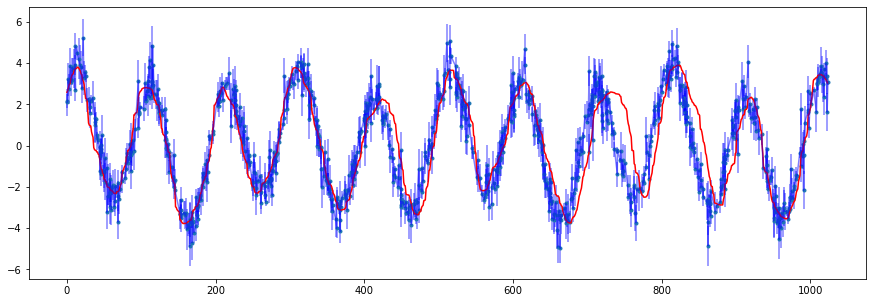

In [18]:
def guess_mc(T, DC1, A1, A2, T0, DC2, A3, A4):
    return DC1+DC2+(A1*np.sin(2*np.pi*(T/100)))+(A2*np.cos(2*np.pi*(T/100)))+(A3*np.sin(2*np.pi*(T/T0)))+(A4*np.cos(2*np.pi*(T/T0)))
def negloglike(params):
    for i in zip(y, t, sigma):
        return np.sum((y - (guess_mc(t, *params)))**2/(sigma**2))

def model(parameters, t) :   
    model = optimize.minimize(negloglike, paramsboth) 
    print(model)
    return guess_mc(t, *model['x'][:])
#model_mc = optimize.curve_fit(guess_mc, t, y, p0=paramsboth)
#print(model_mc)
#y_fit = guess_mc(t, *model_mc['x'][:])
y_fit= model(paramsboth, t)

plt.figure(figsize=(15, 5))
plt.plot(t, y, '.')
plt.errorbar(t, y, yerr=sigma, color="b", alpha=0.5)
plt.plot(y_fit, color="r")
plt.xlabel("time")
plt.ylabel("signal")
plt.title("data set 11")

In [20]:
#x = np.arange(-2.5, 7, 0.01) # parameters

#DC1, A1, A2,period, DC2, A3, A4

def lnprior(parameters): # Return 0 (ie do not change the likelihood) if the params are within bounds
    dc1, a1,a2, period, dc2, a3, a4 = parameters  
    if -10 < (dc1+dc2)  < 10 and  -10 < a1  < 10 and -10 < a2  < 10 and -10 < a3  < 10 and -10 < a4  < 10 and (1/600) < period < 600:
        return 0.0
    else:
        return -np.inf

def lnprob(parameters, signal, t, sigma):
    lp = lnprior(parameters)

    if not lp == 0.0:
        return -np.inf
    return lp - negloglike(parameters)


def proposal(parameters):
    dim = len(parameters)
    return np.array(parameters) + 1e-4 * np.random.randn(dim)


In [21]:
datamcmc = (data[-1], t, sigma)
nwalkers=500
niter=10000
initial = paramsboth
ndim = len(initial)
p0 = [np.asarray(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

In [22]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [25]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,datamcmc)

Running burn-in...
Running production...


      fun: 933.211175462096
 hess_inv: array([[ 5.00013008e-01, -7.81374095e-08, -3.69003051e-06,
         3.73450098e-04, -4.99986992e-01, -7.83981079e-06,
         1.23607512e-05],
       [-7.81374096e-08,  9.12643920e-05,  1.69667105e-06,
        -8.87327529e-05, -7.81374097e-08,  5.50107266e-06,
        -1.27043656e-05],
       [-3.69003051e-06,  1.69667105e-06,  1.06908327e-04,
         1.85057574e-04, -3.69003051e-06, -1.02440112e-05,
        -7.74427361e-06],
       [ 3.73450098e-04, -8.87327529e-05,  1.85057574e-04,
         2.01792509e-01,  3.73450098e-04, -5.89542674e-03,
         6.65945003e-03],
       [-4.99986992e-01, -7.81374099e-08, -3.69003051e-06,
         3.73450098e-04,  5.00013008e-01, -7.83981079e-06,
         1.23607512e-05],
       [-7.83981079e-06,  5.50107266e-06, -1.02440112e-05,
        -5.89542674e-03, -7.83981079e-06,  2.71717662e-04,
        -1.89031738e-04],
       [ 1.23607512e-05, -1.27043656e-05, -7.74427361e-06,
         6.65945003e-03,  1.23607512e-

      fun: 933.211175462096
 hess_inv: array([[ 5.00013008e-01, -7.81374095e-08, -3.69003051e-06,
         3.73450098e-04, -4.99986992e-01, -7.83981079e-06,
         1.23607512e-05],
       [-7.81374096e-08,  9.12643920e-05,  1.69667105e-06,
        -8.87327529e-05, -7.81374097e-08,  5.50107266e-06,
        -1.27043656e-05],
       [-3.69003051e-06,  1.69667105e-06,  1.06908327e-04,
         1.85057574e-04, -3.69003051e-06, -1.02440112e-05,
        -7.74427361e-06],
       [ 3.73450098e-04, -8.87327529e-05,  1.85057574e-04,
         2.01792509e-01,  3.73450098e-04, -5.89542674e-03,
         6.65945003e-03],
       [-4.99986992e-01, -7.81374099e-08, -3.69003051e-06,
         3.73450098e-04,  5.00013008e-01, -7.83981079e-06,
         1.23607512e-05],
       [-7.83981079e-06,  5.50107266e-06, -1.02440112e-05,
        -5.89542674e-03, -7.83981079e-06,  2.71717662e-04,
        -1.89031738e-04],
       [ 1.23607512e-05, -1.27043656e-05, -7.74427361e-06,
         6.65945003e-03,  1.23607512e-

      fun: 933.211175462096
 hess_inv: array([[ 5.00013008e-01, -7.81374095e-08, -3.69003051e-06,
         3.73450098e-04, -4.99986992e-01, -7.83981079e-06,
         1.23607512e-05],
       [-7.81374096e-08,  9.12643920e-05,  1.69667105e-06,
        -8.87327529e-05, -7.81374097e-08,  5.50107266e-06,
        -1.27043656e-05],
       [-3.69003051e-06,  1.69667105e-06,  1.06908327e-04,
         1.85057574e-04, -3.69003051e-06, -1.02440112e-05,
        -7.74427361e-06],
       [ 3.73450098e-04, -8.87327529e-05,  1.85057574e-04,
         2.01792509e-01,  3.73450098e-04, -5.89542674e-03,
         6.65945003e-03],
       [-4.99986992e-01, -7.81374099e-08, -3.69003051e-06,
         3.73450098e-04,  5.00013008e-01, -7.83981079e-06,
         1.23607512e-05],
       [-7.83981079e-06,  5.50107266e-06, -1.02440112e-05,
        -5.89542674e-03, -7.83981079e-06,  2.71717662e-04,
        -1.89031738e-04],
       [ 1.23607512e-05, -1.27043656e-05, -7.74427361e-06,
         6.65945003e-03,  1.23607512e-

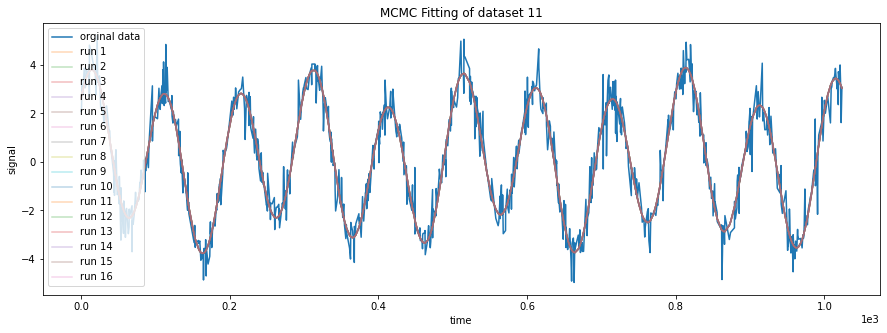

In [50]:
def plotter(sampler):
    plt.figure(figsize=(15, 5))
    plt.ion()
    plt.plot(t,y,label='orginal data')
    samples = sampler.flatchain
    i=1
    for theta in samples[np.random.randint(len(samples), size=16)]:
        plt.plot(t, model(paramsboth, t), alpha=0.3, label="run {}".format(i))
        i+=1
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('time')
    plt.ylabel("signal")
    plt.title("MCMC Fitting of dataset 11")
    plt.legend()
    plt.show()
    
#sampler= main(p0)
plotter(sampler)

In [ ]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]
samples = sampler.flatchain

theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max, t)

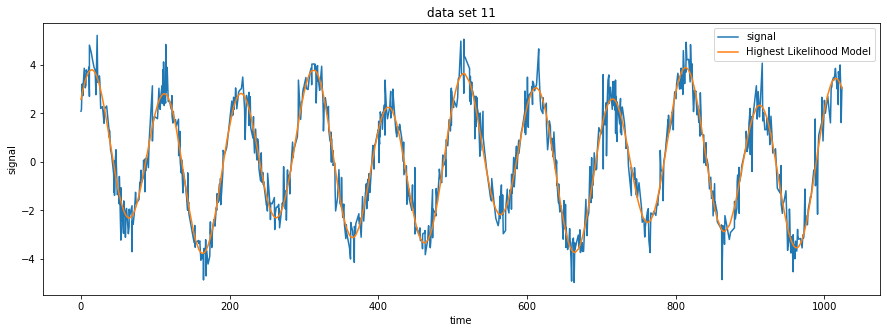

In [45]:
plt.figure(figsize=(15, 5))
plt.plot(t,y,label='signal')
plt.plot(t,best_fit_model,label='Highest Likelihood Model')
plt.xlabel("time")
plt.ylabel("signal")
plt.title("data set 11")
plt.legend()
plt.show()
#print('Theta max: ',theta_max)

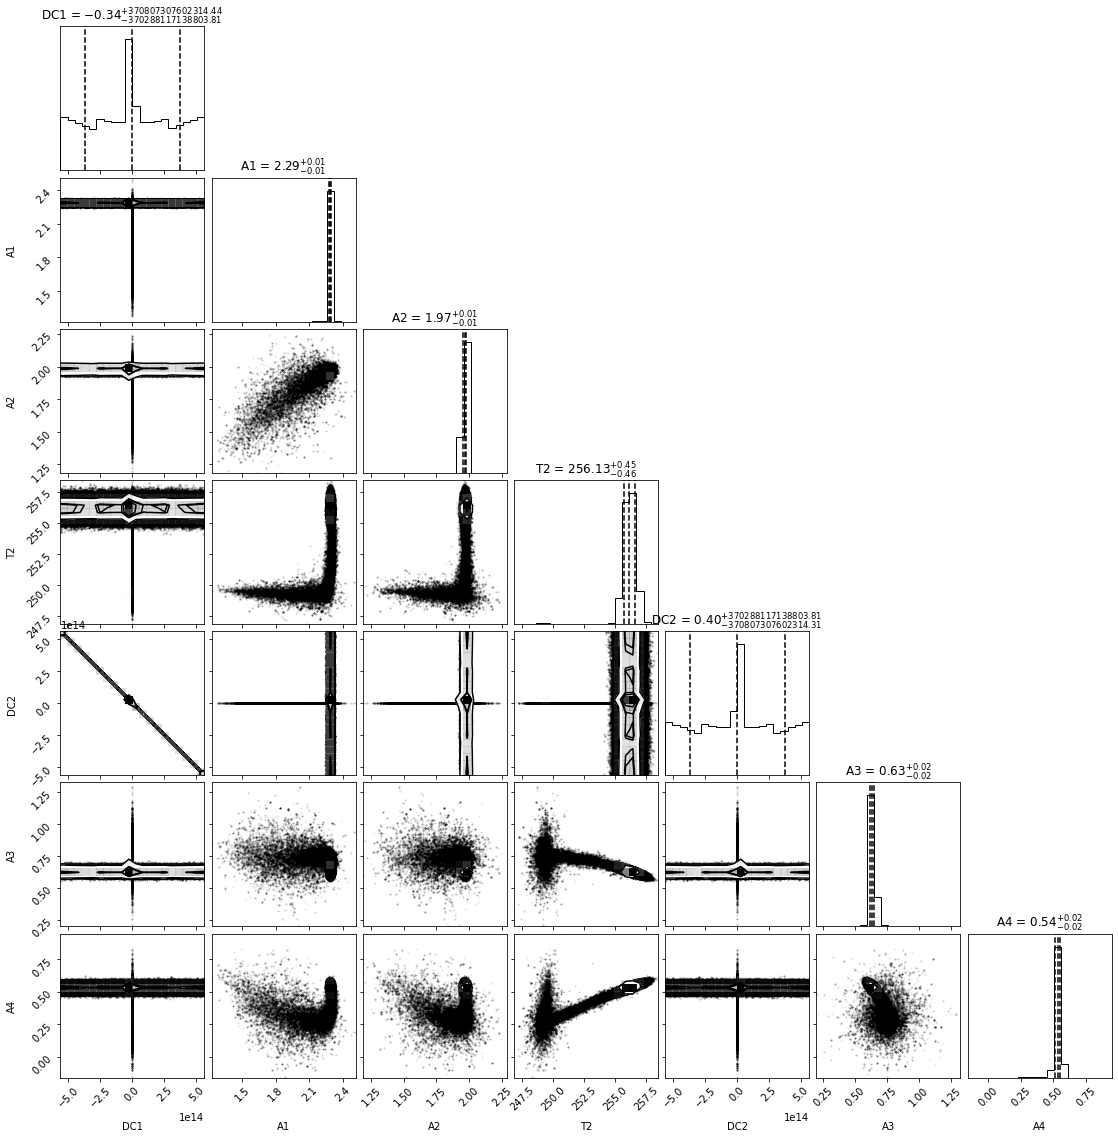

In [42]:
#DC1, A1, A2,period, DC2, A3, A4

labels = ['DC1', 'A1', 'A2', 'T2', 'DC2', 'A3', 'A4'] #T2 = period of second curve
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])


**Problem 2:** Go back to the 11th data set (the last data set) from Problem 2 of Problem Set 2, and plot the residuals (data minus best-fit model expectation) away from the one-period (100-day-period) model, but folded at the period of the putative best-fit second period T. Is it believable? That is, check the model, visually. “Folded” here means instead of plotting against time t you plot against (t % T), because in python % is the mod operator.

In [ ]:
print(y_fit)
print(y)
sub= np.subtract(y, y_fit)
print(sub)
plt.plot(t,sub, '.')

y=sub
params_new = [250,0, 1, 1]

model_sub_y = optimize.minimize(negloglikeextra, params_new)
sub_y_first= guessextra(t, *params_new)
sub_y_fit = guessextra(t, *model_sub_y['x'][:])
print("subtracted signal", "frequency =", model_sub_y['x'][0], "offset =", model_sub_y['x'][1], "amplitude 1 =", model_sub_y['x'][2], "amplitude 2 =", model_sub_y['x'][3])
plt.plot(sub_y_fit)

#clearly, the second signal is around 250 days

In [ ]:
##### 11 #####
y=data[12]
params_new = [255,0, 1, 1]

model_ex1111 = optimize.minimize(negloglikeextra, params_new)
y_first_guess_ex= guessextra(t, *params_new)
y_fit_ex250 = guessextra(t, *model_ex1111['x'][:])
print("second signal", "frequency =", model_ex1111['x'][0], "offset =", model_ex1111['x'][1], "amplitude 1 =", model_ex1111['x'][2], "amplitude 2 =", model_ex1111['x'][3])

plt.figure(figsize=(15, 5))
plt.plot(t, y, '.', color='b')
plt.errorbar(t, y, yerr=sigma, alpha=0.5)
plt.plot(y_fit_ex250, 'y', label='after fitting for second signal')

lik_model100 = optimize.minimize(negloglike100, params100)
y_first_guess100= guess100(t, *params100)
y_fit100 = guess100(t, *lik_model100['x'][:])
print("100 day signal", "offset =", lik_model100['x'][0], "amplitude 1 =", lik_model100['x'][1], "amplitude 2 =", lik_model100['x'][2])
plt.plot(y_fit100, 'g', label='og signal')

plt.xticks(np.arange(0, 1000, 100))
plt.grid()

plt.plot(y_fit100+y_fit_ex250, 'r', label = 'summed curves')

plt.legend()
plt.xlabel("time")
plt.ylabel("signal")
plt.title("data set 11")



In [ ]:
#we will use the "second signal" with the 253.44 day period for the folding
T253=model_ex1111['x'][0]
print(T253)

#plt.figure(figsize=(10, 10))
plt.plot(t%T253, sub, '.', label="residuals")
plt.plot(y_fit_ex250, 'r', label='best fit of second signal')
plt.legend()

plt.xlim(0, 300)
plt.grid()
plt.legend()
plt.xlabel("time % T")
plt.ylabel("signal residuals")
plt.title("Folded Residuals of Data Set 11")

#This totally makes sense and looks good! 
#you can see that second curve and it looks like the best fit guess goes right through it 


**Problem 3:** Re-do problem 2 of Problem Set 2 using K-fold cross-validation with K=8. That is, fit the 1- and 2-period models to all but one eighth of each data set and predict the held-out eighth, and repeat for all eight held-out eighths, for all 11 data sets. Which is a better model in each case? Now compute the AIC and BIC instead. Which is a better model according to these? Make a table, maybe?


In [ ]:
guess_a1 = 1
guess_a2 = 1
guess_offset = 0

#fixed 100 day period

print("100 day period")

def guess100(T, DC, A1, A2):
    parenthesis= 2*np.pi*(T/100)
    return DC+(A1*np.sin(parenthesis))+(A2*np.cos(parenthesis))

params100= [guess_offset, guess_a1, guess_a2]

def negloglike100(params):
    for i in zip(y, t, sigma):
        return np.sum((y - (guess100(t, *params)))**2/(sigma**2))
    
#minimize negloglike with TWO amplitudes at 100 day period
fits100=[]
for i in range(2, 13):
    y=data[i]
    lik_model100 = optimize.minimize(negloglike100, params100)
    y_first_guess100= guess100(t, *params100)
    #print(*lik_model100['x'][:])
    y_fit100 = guess100(t, *lik_model100['x'][:])
    fits100.append(y_fit100)
    print("data set {}".format(i-1))
    print("offset =", lik_model100['x'][0], "amplitude 1 =", lik_model100['x'][1], "amplitude 2 =", lik_model100['x'][2])
    print("Final Amplitude =", np.sqrt((lik_model100['x'][1])**2+((lik_model100['x'][2])**2)))
    
    plt.figure(figsize=(15, 5))
    plt.plot(t, y, '.', color='b')
    plt.errorbar(t, y, yerr=sigma, alpha=0.5)
    #plt.plot(y_fit2, 'm', label='after fitting double')
    plt.plot(y_fit100, 'r', label='after fitting 100 days')
    plt.plot(y_first_guess100, 'g', label='first guess 100 day period')
    plt.xticks(np.arange(0, 1000, 100))
    plt.grid()
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("signal")
    plt.title("data set {}".format(i-1))

In [ ]:
def guess2(T, T0_B, DC, B1, B2):
    parenthesis= 2*np.pi*(T/T0_B)
    return DC+(B2*np.sin(parenthesis))+(B2*np.cos(parenthesis))

def negloglike2(params):
    for i in zip(y, t, sigma):
        return np.sum((y - (guessextra(t, *params)))**2/(sigma**2))


guess_a1 = 1
guess_a2 = 1
guess_offset = 0
guess_freq = [1,50,100,150,200,250]
print(guess_freq)
#print(i) for i in list

params2= [guess_freq, guess_offset, guess_a1, guess_a2]

###optimize curve_fit

for i in range(2, 13):
    y=data[i]
    plt.figure(figsize=(15, 5))
    plt.plot(t, y, '.', color='g')
    plt.errorbar(data[0], data[i], yerr=data[1], alpha=0.5, color='g')    
    plt.plot(fits100[i-2], 'r', label='100 days')
    #plt.plot(y_first_guess, label='first guess')
    for k in range(len(guess_freq)):
        model = optimize.minimize(negloglike2, [guess_freq[k],0,1,1] )
        #fit = optimize.curve_fit(guess2, t, y, p0=[guess_freq[k],0,1,1])
        #y_first_guess= guess2(t, guess_freq[k],0,1,1)
        y_fit = guess2(t, *model['x'][:])
        if  model['x'][3] > 0.1:
            plt.plot(y_fit, label= model['x'][0])
            print('period', model['x'][0], 'amplitude', model['x'][3])
        
    #plt.figure(figsize=(15, 5))
    plt.xlabel("time")
    plt.ylabel("signal")
    plt.title("data set {}".format(i-1))
    plt.legend()
    plt.show()
    #print("frequency =", model_ex['x'][0], "offset =", model_ex['x'][1], "amplitude 1 =", model_ex['x'][2], "amplitude 2 =", model_ex['x'][3])


so just to reiterate-

0 signals : 1, 2, 3

1 signal  : 4, 5, 8, 10

2nd signal : 6, 7, 9, 11
 
138,260,263

In [ ]:
#learning

tst=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
print(len(tst))
n=3
short = np.asarray([tst[i * n:(i + 1) * n] for i in range((len(tst) + n - 1) // n )])
print (len(short), short, short.shape, short.shape[0], short.shape[1])

for i in range(0, 8):
    tst=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
    n=3
    short = np.asarray([tst[i * n:(i + 1) * n] for i in range((len(tst) + n - 1) // n )])
    short[i]=0
    out=short.reshape(-1)
    print(out)

In [ ]:
###This is an example on set 11 to demo how it works to take out 1/8 (it works the same)

#plt.figure(figsize=(15, 5))
for j in range(0,8):
            y=data[-1]
            n=128
            # using list comprehension
            clipped = np.asarray([y[i * n:(i + 1) * n] for i in range((len(y) + n - 1) // n )])
            clipped[j]=0
            finclip=clipped.reshape(-1)
            plt.figure(figsize=(15, 5))
            plt.plot(t, finclip, '.', color='b')
            plt.errorbar(t, finclip, yerr=sigma, alpha=0.5)
            fit = optimize.curve_fit(guess100, t, finclip, p0=params100)
            y_fit = guess100(t, *fit[0])
            plt.plot(y_fit, label="{}/8".format(j+1))
            plt.grid()
            plt.legend()
            plt.xlabel("time")
            plt.ylabel("signal")
            plt.title("data set 11")

In [ ]:
##This is the one period case

for i in range(2, 13):
    plt.figure(figsize=(15, 5))
    for j in range(0,8):
            y=data[i]
            n=128
            # using list comprehension
            clipped = np.asarray([y[i * n:(i + 1) * n] for i in range((len(y) + n - 1) // n )])
            clipped[j]=0
            finclip=clipped.reshape(-1)
            
            #plt.plot(t, finclip, '.', color='b')
            #plt.errorbar(t, finclip, yerr=sigma, alpha=0.5)
            fit = optimize.curve_fit(guess100, t, finclip, p0=params100)
            y_fit = guess100(t, *fit[0])
            plt.plot(y_fit, label="{}/8".format(j+1))
            plt.grid()
            plt.legend()
            plt.xlabel("time")
            plt.ylabel("signal")
            plt.title("data set {}".format(i-1))

In [ ]:
##this is the two period case

guess_freq=[150,250]
for i in range(2, 13):
    #y=data[i]
    plt.figure(figsize=(15, 5))
    #plt.plot(t, y, '.', color='b')
    #plt.errorbar(t, y, yerr=sigma, alpha=0.5)
    for j in range(0,8):
            y=data[i]
            n=128
            # using list comprehension
            clipped = np.asarray([y[i * n:(i + 1) * n] for i in range((len(y) + n - 1) // n )])
            clipped[j]=0
            finclip=clipped.reshape(-1)
            
            #plt.plot(t, finclip, '.', color='b')
            #plt.errorbar(t, finclip, yerr=sigma, alpha=0.5)
            fit = optimize.curve_fit(guess100, t, finclip, p0=params100)
            y_fit = guess100(t, *fit[0])
            plt.plot(y_fit, label="{}/8".format(j+1))
            
            for k in range(len(guess_freq)):
                model = optimize.minimize(negloglike2, [guess_freq[k],0,1,1] )
                y_fit2 = guess2(t, *model['x'][:])
                if  model['x'][3] > 0.4:
                    #plt.plot(y_fit, label= model['x'][0])
                    #print('period', model['x'][0], 'amplitude', model['x'][3])
                    plt.plot(y_fit+y_fit2, label= model['x'][0])
                    print("data set", i-1, "has a second signal at", model['x'][0])
            plt.grid()
            plt.legend()
            plt.xlabel("time")
            plt.ylabel("signal")
            plt.title("data set {}".format(i-1))

Now compute the AIC and BIC instead

AIC = 2 * p - 2 * LL 

BIC = ln(N) * p - 2 * LL

**want to minimize AIC and BIC**

In [ ]:
from scipy.stats import norm

def AIC(y, y_fit, sigma, p): #AIC = 2k - 2 * LL
    LL=np.sum(norm.logpdf(y, y_fit, sigma))
    return (2*(p/len(y))) - ((2/len(y)) * LL)

def BIC(y, y_fit, sigma, p): #BIC = ln(N) * k - 2 * LL
    LL=np.sum(norm.logpdf(y, y_fit, sigma))
    return np.log(len(y))*p - 2/len(y)*LL
    


In [ ]:
##Comparing the one period (orange) and two period(red) models. 
#The two period model works better, as if there is no secondary signal it works just as good, and it works better if there is in fact a second signal
#overall it works about as good as it did with 7/8 of the data as it did with 8/8 

mean_aic100 = []
mean_bic100 = []
aic_list100=[0]
bic_list100=[0] #just so it doesn't throw error
mean_aic = []
mean_bic = []
aic_list=[0]
bic_list=[0] #just so it doesn't throw error
guess_freq=[1,50,150,200,250]

print("orange is one period fit, red is two period fit")
for i in range(2, 13):
    mean_aic100.append(np.mean(aic_list100))
    aic_list100=[]
    mean_bic100.append(np.mean(bic_list100))
    bic_list100=[]

    mean_aic.append(np.mean(aic_list))
    aic_list=[]
    mean_bic.append(np.mean(bic_list))
    bic_list=[]
    
    y=data[i]
    plt.figure(figsize=(15, 7))
    plt.plot(t, y, '.', color='b')
    plt.errorbar(t, y, yerr=sigma, alpha=0.5)
    for j in range(0,8):
            y=data[i]
            n=128
            # using list comprehension, this removes 1/8th
            clipped = np.asarray([y[i * n:(i + 1) * n] for i in range((len(y) + n - 1) // n )])
            clipped[j]=0
            finclip=clipped.reshape(-1)
            
            #this portion does the 100 day period fit to the 7/8ths
            fit = optimize.curve_fit(guess100, t, finclip, p0=params100)
            y_fit = guess100(t, *fit[0])
            plt.plot(y_fit,'orange')
            
            aic100=AIC(finclip, y_fit, sigma, 3)
            aic_list100.append(aic100)
            bic100=BIC(finclip, y_fit, sigma, 3)
            bic_list100.append(bic100)
            #print("AIC, BIC for 100 day", aic,bic)
            
            #this portion does multiple guesses at the second period curve
            for k in range(len(guess_freq)):
                model = optimize.minimize(negloglike2, [guess_freq[k],0,1,1] )
                y_fit2 = guess2(t, *model['x'][:])
                if  model['x'][3] > 0.2: #if the second curve is significant
                    aic=AIC(finclip, y_fit+y_fit2, sigma, 7)
                    aic_list.append(aic)
                    bic=BIC(finclip, y_fit+y_fit2, sigma, 7)
                    bic_list.append(bic)
                    plt.plot(y_fit+y_fit2, 'r')      #plot sum of curves
            plt.grid()
            #plt.legend()
            plt.xlabel("time")
            plt.ylabel("signal")
            plt.title("data set {}".format(i-1))
            
mean_aic100.append(np.mean(aic_list100))
mean_bic100.append(np.mean(bic_list100))
mean_aic.append(np.mean(aic_list))
mean_bic.append(np.mean(bic_list))

mean_aic100.pop(0)
mean_bic100.pop(0)
mean_aic.pop(0)
mean_bic.pop(0)

In [ ]:


print("AIC for 100 day")
print(mean_aic100)
print("AIC with two signals")
print(mean_aic)

print("BIC for 100 day")
print(mean_bic100)
print("BIC with two signals")
print(mean_bic)

#a minimized AIC is better

the nan values make sense, since they correspond to the curves with only one signal. 
        

In [ ]:
from tabulate import tabulate
from pathlib import Path
 
# assign data
mydata = [
    mean_aic100,
    mean_aic,
    mean_bic100,
    mean_bic,
]
 
# create header
head = [1,2,3,4,5,6,7,8,9,10,11]
 
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

file_output = Path('test.txt')
file_output.write_text(tabulate(tabulate(mydata, headers=head, tablefmt="grid")))

the table looks bad, but basically smaller numbers are better. That means that the AIC says the model did much better. I think because the AIC is better suited to lots of data and complex models (therefore prone to overfitting).

In [ ]:
print(np.asarray(mean_aic100)-np.asarray(mean_aic))
print(np.asarray(mean_bic100)-np.asarray(mean_bic))

These difference calculations say that for the AIC, the 2 signal model was worse for signals 6 and 11 and better for signals 9 and 11. For the BIC, the 2 signal model was worse for all of the 2 signal datasets (6,7,9,11), and that is because BIC punishes more parameters more severely, so the 4 extra parameters are heavily punished.

## 